In [136]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from scipy.spatial import ConvexHull
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import Window
from pyspark.ml.feature import Normalizer
from pyspark.mllib.linalg.distributed import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from scipy.stats import *

import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
os.environ['ARROW_PRE_0_15_IPC_FORMAT']='1'


In [6]:
sc = SparkSession.builder.getOrCreate()
sc.conf.set("spark.sql.execution.arrow.enabled", "true")

In [7]:
test_data = datasets.make_blobs(
    n_samples = 14000, centers = 7, n_features = 2, cluster_std = [100,150,200,300,250,800,250], shuffle = False,
    random_state = 44, center_box=(1000,5500))
#rs 15
df_agi = pd.DataFrame(test_data[0])
df_agi.columns = ['AGI','Refund']
df_agi['label'] = test_data[1]
df_agi['id'] = df_agi.index
df_agi["AGI"] = df_agi["AGI"] * 20

In [8]:
pd.DataFrame(test_data[1])[0].value_counts()

6    2000
5    2000
4    2000
3    2000
2    2000
1    2000
0    2000
Name: 0, dtype: int64

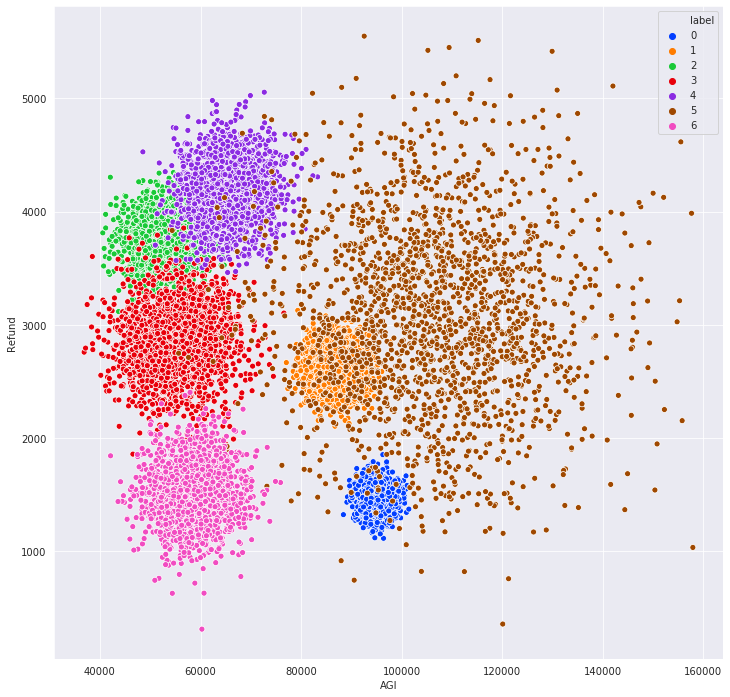

In [9]:
sns.set_style("darkgrid")

g = sns.scatterplot(x = df_agi.AGI, y = df_agi.Refund, hue = df_agi.label, palette='bright')
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [207]:
SAMPLE_AMOUNT = 500
samp_rand = df_agi.sample(SAMPLE_AMOUNT)

# more or less normal clusters
cluster_1 = df_agi[((df_agi["label"] == 2) | (df_agi["label"] == 3) | (df_agi["label"] == 4))]
cluster_2 = df_agi[((df_agi["label"] == 5) | (df_agi["label"] == 0) | (df_agi["label"] == 1))]
cluster_3 = df_agi[((df_agi["label"] == 4) | (df_agi["label"] == 6) | (df_agi["label"] == 1))]


# clusters that should show some issues
cluster_4 = df_agi[((df_agi["label"] == 3) | (df_agi["label"] == 6) | (df_agi["label"] == 0))]
cluster_5 = df_agi[((df_agi["label"] == 5) | (df_agi["label"] == 0) | (df_agi["label"] == 1))]
cluster_6 = df_agi[((df_agi["label"] == 3) | (df_agi["label"] == 5) | (df_agi["label"] == 1))]

clusters=[cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]


In [208]:
cluster_samples = [cluster.sample(SAMPLE_AMOUNT) for cluster in clusters]


In [209]:
avg = np.average(cluster_samples[0].loc[:,['AGI','Refund']], axis=0).reshape(2,1)

    

In [210]:
cluster_samples[3]

,AGI,Refund,label,id
7039,30010.213188,1669.894676,3,7039
6400,28993.921369,1353.610165,3,6400
539,61123.972075,1029.830793,0,539
425,63814.598771,925.078413,0,425
6848,31540.803715,1541.049596,3,6848
...,...,...,...,...
6779,18903.892633,1537.254844,3,6779
12765,53871.647987,3227.412205,6,12765
12772,48645.980707,3106.336435,6,12772
7741,28847.602401,1310.173403,3,7741


In [211]:
def find_centroid(cluster_data, distances = False):
    data = cluster_data
    cent = np.average(data, axis=0).reshape(2,1)
    
    if distances:
        dists  = np.sqrt(np.square(data.T - cent).sum(axis=0))
        return cent, dists
    else:
        return cent.T[0]

In [212]:
def show_centroid_vectors(cluster_data, centroid):
    
    for row in cluster_data:
        
        plt.plot([row[0], centroid[0]], [row[1], centroid[1]], 'grey', linewidth = .5)
        
    sns.scatterplot(x = cluster_data[:,0], y = cluster_data[:,1])
        
    plt.plot(centroid[0], centroid[1], marker='o', markersize=8, color="red")
        
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    return None

In [213]:
def cluster_scaler(cluster, minmax = True):
    
    data = np.array(cluster.loc[:,['AGI','Refund']])
    
    if minmax:
        minmax = MinMaxScaler()
        return minmax.fit_transform(data)
    
    else:
        z_scale = StandardScaler()
        return z_scale.fit_transform(data)


In [214]:
clust_1_minmax= cluster_scaler(cluster_samples[4])

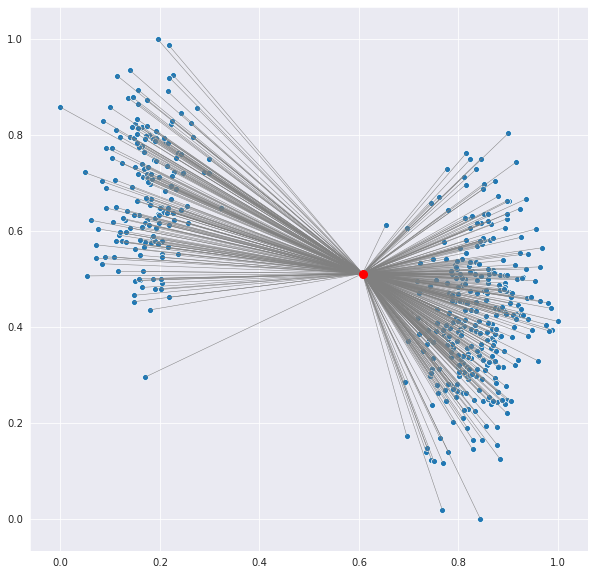

In [215]:
centroid, dists1 = find_centroid(clust_1_minmax, distances=True)
show_centroid_vectors(clust_1_minmax, centroid)

In [216]:
def find_angles(cluster_data, centroid):
    diffs = (cluster_data.T - centroid).T
    angles = np.arctan2(diffs[:,1], diffs[:,0])
    angles = [x + 2*np.pi if x<=0 else x for x in angles]
    
    
    return angles


In [217]:
find angles

SyntaxError: invalid syntax (<ipython-input-217-9b94d9dfa676>, line 1)

In [ ]:
def plot_distributions_2d(cluster_data):

    centroid, dists = find_centroid(cluster_data, distances=True)
    angles = find_angles(cluster_data, centroid)

    fig, axs = plt.subplots(2,1)
    sns.distplot(angles, bins=15)
    plt.xlim(-np.pi,np.pi)
    
    plt.axes(axs[0])
    sns.distplot(dists, bins=15)
    plt.xlim(0,1)

    fig.set_size_inches(16,8)

    return None


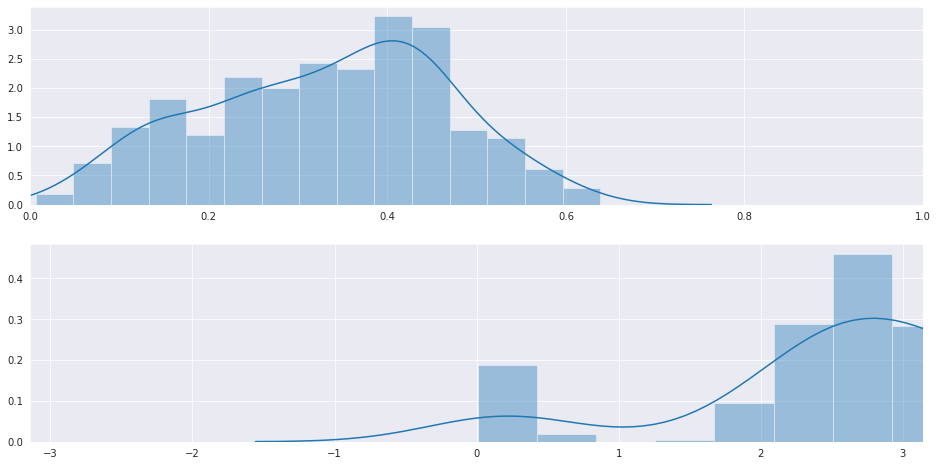

In [218]:
clust_minmax = cluster_scaler(cluster_samples[5])
plot_distributions_2d(clust_minmax)

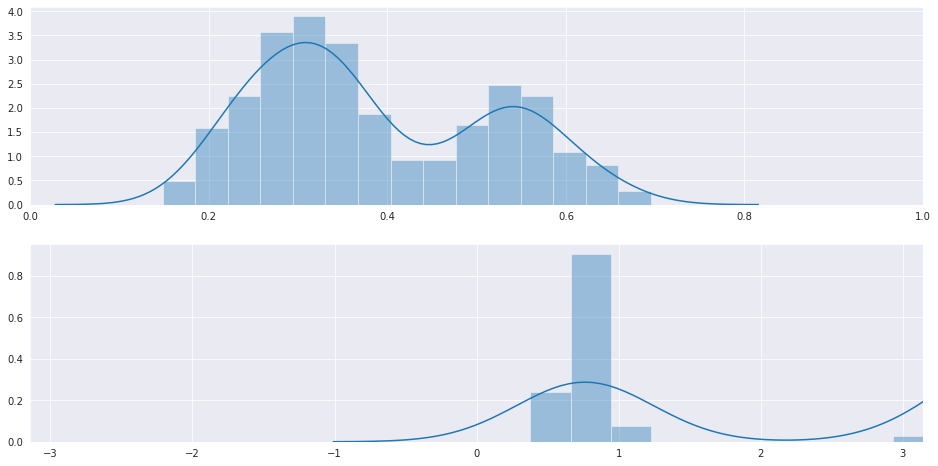

In [219]:
clust_minmax = cluster_scaler(cluster_samples[2])
plot_distributions_2d(clust_minmax)

In [220]:
centroid, dists1 = find_centroid(clust_1_minmax, distances=True)
angles1 = find_angles(clust_1_minmax, centroid)

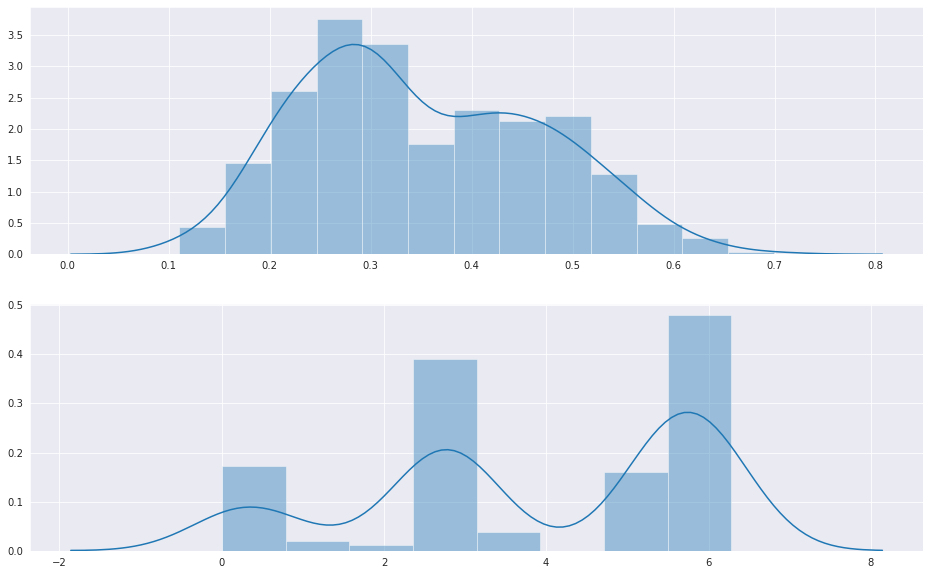

In [221]:
fig, axs = plt.subplots(2,1)
sns.distplot(angles1)
plt.axes(axs[0])
sns.distplot(dists1)
fig.set_size_inches(16,10)

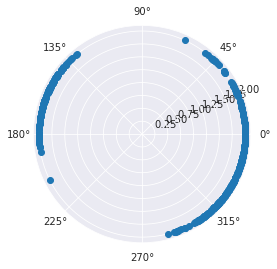

In [223]:
plt.axes(projection='polar')
plt.polar(angles1, np.full(500,2), 'o') 
plt.show()

In [224]:
cluster_dists = []
for cluster in cluster_samples:
    cluster_data = cluster_scaler(cluster)
    centroid, dists = find_centroid(cluster_data, distances=True)
    angles = find_angles(cluster_data, centroid)
    cluster_dists.append((dists, angles))
    

In [225]:
def pairwise_ks_array(cluster_dists, data="dist"):
    
    if data == "dist":
        dist_array =[[ks_2samp(cluster1[0], cluster2[0])[0] for cluster1 in cluster_dists] for cluster2 in cluster_dists]
        
        
    elif data == "angle":
        dist_array =[[ks_2samp(cluster1[1], cluster2[1])[0] for cluster1 in cluster_dists] for cluster2 in cluster_dists]
                
    else:
        raise Exception('not a valid data arg')
        
    return dist_array

In [226]:
pd.DataFrame(pairwise_ks_array(cluster_dists))

,0,1,2,3,4,5
0,0.000,0.208,0.300,0.516,0.244,0.264
1,0.208,0.000,0.192,0.382,0.116,0.116
2,0.300,0.192,0.000,0.230,0.160,0.192
3,0.516,0.382,0.230,0.000,0.316,0.302
4,0.244,0.116,0.160,0.316,0.000,0.142
5,0.264,0.116,0.192,0.302,0.142,0.000


In [227]:
pd.DataFrame(pairwise_ks_array(cluster_dists, data='angle'))

,0,1,2,3,4,5
0,0.000,0.302,0.264,0.138,0.302,0.262
1,0.302,0.000,0.500,0.206,0.046,0.242
2,0.264,0.500,0.000,0.334,0.502,0.274
3,0.138,0.206,0.334,0.000,0.218,0.242
4,0.302,0.046,0.502,0.218,0.000,0.244
5,0.262,0.242,0.274,0.242,0.244,0.000


In [228]:
def pairwise_ep_array(cluster_dists, data="dist"):
    
    if data == "dist":
        dist_array =[[epps_singleton_2samp(cluster1[0], cluster2[0])[0] for cluster1 in cluster_dists] for cluster2 in cluster_dists]
        
        
    elif data == "angle":
        dist_array =[[epps_singleton_2samp(cluster1[1], cluster2[1])[0] for cluster1 in cluster_dists] for cluster2 in cluster_dists]
                
    else:
        raise Exception('not a valid data arg')
        
    return dist_array

In [229]:
pd.DataFrame(pairwise_ep_array(cluster_dists))

,0,1,2,3,4,5
0,0.000000,131.165848,255.201464,472.971081,142.773174,86.739396
1,131.165848,0.000000,59.923784,394.359864,19.180987,83.287942
2,255.201464,59.923784,0.000000,317.073766,55.529792,139.801843
3,472.971081,394.359864,317.073766,0.000000,222.360950,204.413032
4,142.773174,19.180987,55.529792,222.360950,0.000000,61.216531
5,86.739396,83.287942,139.801843,204.413032,61.216531,0.000000


In [230]:
pd.DataFrame(pairwise_ep_array(cluster_dists, data='angle'))

,0,1,2,3,4,5
0,0.000000,168.588010,176.213451,50.623986,171.524023,281.760206
1,168.588010,0.000000,485.481194,294.292725,3.069275,84.177286
2,176.213451,485.481194,0.000000,1165.888689,515.297686,622.842619
3,50.623986,294.292725,1165.888689,0.000000,285.998923,365.332684
4,171.524023,3.069275,515.297686,285.998923,0.000000,71.063373
5,281.760206,84.177286,622.842619,365.332684,71.063373,0.000000


In [231]:
cluster_dists = []
for cluster in clusters:
    cluster_data = cluster_scaler(cluster)
    centroid, dists = find_centroid(cluster_data, distances=True)
    angles = find_angles(cluster_data, centroid)
    cluster_dists.append((dists, angles))

In [232]:
entropies = []
for cluster in cluster_dists:
    angle_hist = np.histogram(cluster[0], bins = int(np.ceil(np.sqrt(len(cluster[0])))))
    distance_hist = np.histogram(cluster[1], bins = int(np.ceil(np.sqrt(len(cluster[0])))))
                                 
    distance_entropy = entropy(distance_hist[0]) - np.log(distance_hist[1][1]-distance_hist[1][0])
    angle_entropy = entropy(angle_hist[0]) - np.log(angle_hist[1][1]-angle_hist[1][0])
    
    entropies.append((distance_entropy, angle_entropy))
    
pd.DataFrame(entropies, columns = ['distance','angle'])

,distance,angle
0,6.695829,8.801444
1,6.080824,8.760900
2,6.326417,8.661065
3,6.151683,8.722123
4,6.080824,8.760900
5,6.358346,8.815294


In [233]:
entropies2 = []
for cluster in cluster_samples:
    agi_hist = np.histogram(cluster['AGI'], bins = int(np.ceil(np.sqrt(len(cluster['AGI'])))))
    refund_hist = np.histogram(cluster['Refund'], bins = int(np.ceil(np.sqrt(len(cluster['Refund'])))))
                                 
    agi_entropy = entropy(agi_hist[0]) - np.log(agi_hist[1][1]-agi_hist[1][0])
    refund_entropy = entropy(refund_hist[0]) - np.log(refund_hist[1][1]-refund_hist[1][0])
    
    entropies2.append((agi_entropy,  refund_entropy))
    
pd.DataFrame(entropies2, columns = ['agi','refund'])

,agi,refund
0,-4.487656,-1.476665
1,-5.752657,-1.463969
2,-5.498454,-2.218598
3,-4.905757,-2.355051
4,-5.737590,-1.435538
5,-5.304479,-1.283675


In [234]:
test_data = datasets.make_blobs(
    n_samples = 14000, centers = 7, n_features = 2, cluster_std = [200,200,200,200,200,200,200], shuffle = False,
    random_state = 15, center_box=(500,3500))

df_agi = pd.DataFrame(test_data[0])
df_agi.columns = ['AGI','Refund']
df_agi['label'] = test_data[1]
df_agi['id'] = df_agi.index
df_agi["AGI"] = df_agi["AGI"] * 20

In [235]:
SAMPLE_AMOUNT = 100

samp_rand = df_agi.sample(SAMPLE_AMOUNT)
samp_clust_01 = df_agi[((df_agi["label"] == 0) | (df_agi["label"] == 1))].sample(SAMPLE_AMOUNT)
samp_clust_02 = df_agi[((df_agi["label"] == 0) | (df_agi["label"] == 6))].sample(SAMPLE_AMOUNT)
samp_clust_03 = df_agi[((df_agi["label"] == 1) | (df_agi["label"] == 3) | (df_agi["label"] == 5))].sample(SAMPLE_AMOUNT)

samp_clust = [samp_rand, samp_clust_01, samp_clust_02, samp_clust_03]

In [236]:
entropies3 = []
for cluster in samp_clust:
    agi_hist = np.histogram(cluster['AGI'], bins = int(np.ceil(np.sqrt(len(cluster['AGI'])))))
    refund_hist = np.histogram(cluster['Refund'], bins = int(np.ceil(np.sqrt(len(cluster['Refund'])))))
                                 
    agi_entropy = entropy(agi_hist[0]) - np.log(agi_hist[1][1]-agi_hist[1][0])
    refund_entropy = entropy(refund_hist[0]) - np.log(refund_hist[1][1]-refund_hist[1][0])
    
    entropies3.append((agi_entropy,  refund_entropy))
    
pd.DataFrame(entropies3, columns = ['agi','refund'])

,agi,refund
0,-6.820486,-3.869578
1,-7.223511,-2.682019
2,-5.385780,-4.010288
3,-6.897362,-2.949650


In [237]:
samp_dists = []
for cluster in samp_clust:
    cluster_data = cluster_scaler(cluster)
    centroid, dists = find_centroid(cluster_data, distances=True)
    angles = find_angles(cluster_data, centroid)
    samp_dists.append((dists, angles))
    
entropies_4 = []
for cluster in samp_dists:
    distance_hist = np.histogram(cluster[0], bins = int(np.ceil(np.sqrt(len(cluster[0])))))
    angle_hist = np.histogram(cluster[1], bins = int(np.ceil(np.sqrt(len(cluster[1])))))
    print(angle_hist)
                                 
    distance_entropy = entropy(distance_hist[0]) - np.log(distance_hist[1][1]-distance_hist[1][0])
    angle_entropy = entropy(angle_hist[0]) - np.log(angle_hist[1][1]-angle_hist[1][0])
    
    entropies_4.append((distance_entropy,  angle_entropy))

(array([11,  0,  9,  8, 33,  6,  3,  3,  4, 23]), array([0.90434854, 1.44141766, 1.97848679, 2.51555591, 3.05262504,
       3.58969416, 4.12676329, 4.66383241, 5.20090154, 5.73797066,
       6.27503979]))
(array([ 2,  0,  0, 19, 28,  3,  1,  0, 10, 37]), array([0.02873569, 0.64328839, 1.2578411 , 1.8723938 , 2.4869465 ,
       3.1014992 , 3.71605191, 4.33060461, 4.94515731, 5.55971002,
       6.17426272]))
(array([ 5,  8, 23, 17,  0,  0,  1,  6, 17, 23]), array([0.76022487, 1.25175745, 1.74329004, 2.23482262, 2.72635521,
       3.2178878 , 3.70942038, 4.20095297, 4.69248555, 5.18401814,
       5.67555073]))
(array([ 7,  1,  3, 17, 27,  9,  7,  0,  6, 23]), array([0.11365827, 0.72752981, 1.34140135, 1.95527289, 2.56914443,
       3.18301597, 3.79688751, 4.41075905, 5.0246306 , 5.63850214,
       6.25237368]))


In [238]:
entropies_4

[(4.751416591728878, 2.495039394367297),
 (4.868610658458445, 1.9864506563277171),
 (5.28418566479878, 2.5554445650269093),
 (4.85862903025455, 2.3898123132232767)]